## 1. Import Libraries

In [1]:
import os
import sys
import torch
import zipfile
import numpy as np # number python
from torch import nn # neural network (Conv2D - 2D Convolution Layer, Linear, Logistic)
from torch.nn import functional as F # activation function (ReLU, Sigmoid, SoftMax)
import torch.utils.data as td # tools to create & load dataset
import torchvision as tv # torchvision library for computer vision tasks
import pandas as pd # library for data analysis, manipulation -> data augmentation
from PIL import Image # library used for image handling
from matplotlib import pyplot as plt # plotting library to plot & visualize results
from sklearn.model_selection import train_test_split # function used to split training set

In [2]:
print(f'PyTorch Version: {torch.__version__}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(torch.cuda.get_device_name())

try: 
    print(f'CUDA Version: {torch.version.cuda}')
except:
    pass

PyTorch Version: 2.5.1+cu121
cuda
NVIDIA GeForce RTX 4070 Laptop GPU
CUDA Version: 12.1


## 2. Loading & Processing Dataset

### Dataset Location

In [3]:
dataset_root_dir = 'E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/'

### Data Processing 

#### Data Augmentation

In [132]:
class BirdDataset(td.Dataset):  # td.Dataset is a class from torch.utils.data
    def __init__(self, root_dir, mode="train", image_size=(224,224), transform=None):
        super().__init__()
        self.image_size = image_size
        self.mode = mode
        self.transform = transform
        
        if mode == "train":
            txt_path = os.path.join(root_dir, 'train.txt')
            self.images_dir = os.path.join(root_dir, 'Train') # Use Train folder
        else: # mode is "test" or "val"
            txt_path = os.path.join(root_dir, 'test.txt')
            self.images_dir = os.path.join(root_dir, 'Test') # safer to use root_dir here
        
        # Loading .txt file (train.txt / val.txt)
        txt_path = os.path.join(root_dir, f'{mode}.txt')
        print("Text File:", txt_path)
        self.data = pd.read_csv(txt_path, sep=" ", header=None, names=["file_path", "class"])

        # Store transform
        self.train_transform = tv.transforms.Compose([
            tv.transforms.RandomResizedCrop(self.image_size),
            tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.CenterCrop(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "BirdDataset: (mode='{}', image_size={})".format(self.mode, self.image_size)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = os.path.join(self.images_dir, self.data.iloc[idx]['file_path'])
        img = Image.open(img_path).convert('RGB') 
        label = self.data.iloc[idx]['class']

        # Apply transform if provided, else default
        transform_to_apply = self.transform or (self.train_transform if "train" in self.mode else self.val_transform)
        img = transform_to_apply(img)


        return img, label

    def number_of_classes(self):
        return self.data['class'].max() + 1        

### View Modified Dataset

In [5]:
def show_img(image, ax=plt):
    # ax = axies object, plot area. ax=plt means default value for ax parameter

    image = image.to('cpu').numpy()
    # moves the tensor to the CPU because Matplotlib can only work with NumPy arrays that are on the CPU, not PyTorch tensors on the GPU.
    
    image = np.moveaxis(image, [0,1,2], [2,0,1])
    # Matplotlib expects different axes (H,W,C) compared to PyTorch (C,W,H)

    image = (image + 1) / 2
    # Unnormalize image

    image[image < 0] = 0
    image[image > 1] = 1

    i = ax.imshow(image)
    # matplotlib function that displays image

    ax.axis("off")

    return i

In [6]:
# Get sample from Training Set

# Create instance of dataset class (BirdDataset)
train_set = BirdDataset(dataset_root_dir)
x = train_set[10]

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/train.txt


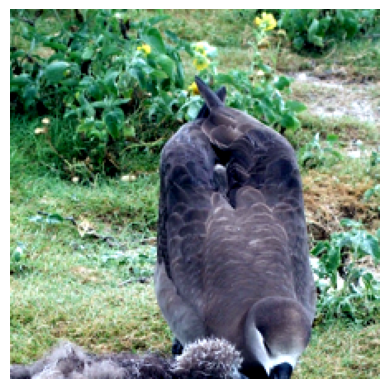

In [7]:
# Create Figure
plt.figure()
show_img(x[0])
# x is from the sample, and 0 is the index for image array x

### Loading Data

In [8]:
# Load Data thoruhg mini-batch size
train_loader = td.DataLoader(train_set, batch_size=32, shuffle = True, pin_memory = True)
# Use mini-batch size 16
# Shufffle so that the model does not predict based off data order
# pin_memory = True -> Speeds up transfer to the GPU

In [9]:
# How many mini-batches there are.
len(train_loader)

151

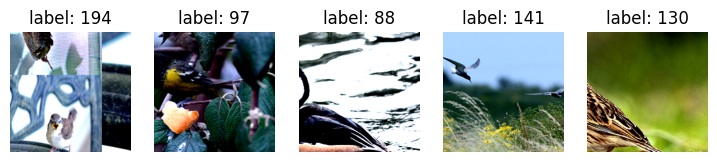

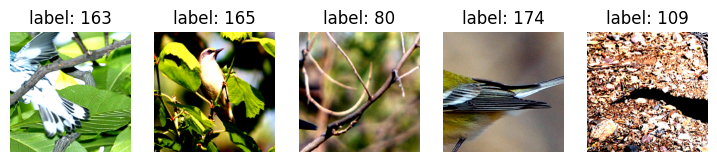

In [10]:
for _ in range(2):
   # _ is a throwaway variable
    fig, axes = plt.subplots(ncols=5, figsize=(9, 3))
    # Create Matplotlib figure with 5 subplots 
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx == 5: 
            break
        show_img(batch[0][0], ax=axes[batch_idx])
        # batch[0] -> images tensor of the batch, batch[0][0] -> images tensor index (0 being the first index)
        # ax tells the image to plot on their respective subplot
        axes[batch_idx].set_title(f'label: {batch[1][0]}')
        # batch[1] -> represents the class label no.
        

Batch is a tuple(images, labels). Batch[0] represents Image Tensor and Batch[1] represents Labels Tensor

# 3. Validation Dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
txt_path = os.path.join(dataset_root_dir, "train.txt")
full_data = pd.read_csv(txt_path, sep=" ", header=None, names=["file_path", "class"])

In [13]:
train_df, val_df = train_test_split(
    full_data,
    test_size=0.2,          # 20% for validation
    random_state=42,        # for reproducibility
    stratify=full_data['class']  # preserve class distribution
)

In [14]:
train_split_path = os.path.join(dataset_root_dir, "train_split.txt")
val_split_path = os.path.join(dataset_root_dir, "val_split.txt")

train_df.to_csv(train_split_path, sep=" ", header=False, index=False)
val_df.to_csv(val_split_path, sep=" ", header=False, index=False)

In [16]:
train_set = BirdDataset(dataset_root_dir, mode="train_split")
val_set = BirdDataset(dataset_root_dir, mode="val_split")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/train_split.txt
Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/val_split.txt


### Classifier Class

In [17]:
import torch.nn as nn

In [18]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## 4. Transfer Learning - Convolutional Neural Network

### Load Pre-trained VGG Model

In [19]:
from torchvision.models import VGG16_BN_Weights, vgg16_bn

In [20]:
# vgg = tv.models.vgg16_bn(pretrained = True)

# vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V)

vgg = tv.models.vgg16_bn(pretrained = True)

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [22]:
# List all the parameters in the transferred model
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

# features.0.weight torch.Size([64, 3, 3, 3]) True
# Outputs: 64 Filters, 3 input channels, 3 x 3 kernel size 

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

### Fine-Tuning & Freezing

In [23]:
import nntools as nt

In [24]:
class VGG16(Classifier):
    def __init__(self, num_classes, fine_tuning=False, dropout_p=0.5):
        super().__init__()
        # Load pretrained VGG16 with batchnorm
        vgg = tv.models.vgg16_bn(pretrained=True)
        
        # Freeze parameters if not fine-tuning
        # for param in vgg.parameters():
           # param.requires_grad = fine_tuning


        for name, param in vgg.features.named_parameters():
            layer_idx = int(name.split('.')[0])  # extract the index before the dot
            if layer_idx in [0, 3, 7]:          # only freeze these specific layers
                param.requires_grad = False


        
        self.features = vgg.features

        # Droupout Value
        dropout_p = 0.5
        
        # Customize classifier
        num_ftrs = vgg.classifier[0].in_features if hasattr(vgg.classifier[0], 'in_features') else 25088
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        f = self.features(x).view(x.shape[0], -1)
        y = self.classifier(f)
        return y


In [25]:
num_classes = train_set.number_of_classes()

In [26]:
vgg16transfer = VGG16(num_classes)

In [27]:
vgg16transfer

VGG16(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [28]:
for name, param in vgg16transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) False
features.0.bias torch.Size([64]) False
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) False
features.3.bias torch.Size([64]) False
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) False
features.7.bias torch.Size([128]) False
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features

In [29]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}


#### Learning Rate 1

In [30]:
lr = 5e-5
net = VGG16(num_classes = num_classes, fine_tuning=True).to(device)
net = net.to(device)
net.device = device

adam = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 1e-4)

stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

In [31]:
with open("birdclass1/config.txt", "r") as f:
    print(f.read())

Net(VGG16(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
#lr = 1e-4
#net = VGG16(num_classes)
#net = net.to(device)
adam = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 1e-4)
#stats_manager = ClassificationStatsManager()
try:
    #exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
    #          output_dir="birdclass1", perform_validation_during_training=True)

    exp1 = nt.Experiment(
        net, train_set, val_set, adam, stats_manager,
        output_dir="birdclass1",
        perform_validation_during_training=True
    )
except ValueError:
    print("ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.")

#### Training Snippet

##### Early Stopping

In [54]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience: number of epochs to wait after last improvement
            min_delta: minimum change to consider as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter if improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [55]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    
    def to_float(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().item()
        return x

    # Training and Validation loss
    axes[0].plot([to_float(exp.history[k][0]['loss']) for k in range(exp.epoch)],
                 label="training loss")
    axes[0].plot([to_float(exp.history[k][1]['loss']) for k in range(exp.epoch)],
                 label="Validation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Training and Validation accuracy
    axes[1].plot([to_float(exp.history[k][0]['accuracy']) for k in range(exp.epoch)],
                 label="training accuracy")
    axes[1].plot([to_float(exp.history[k][1]['accuracy']) for k in range(exp.epoch)],
                 label="Validation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')

    # Add text for current epoch
    axes[0].text(0.95, 0.95, f"Epoch {exp.epoch}", 
                 transform=axes[0].transAxes, ha='right', va='top',
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
    
    plt.tight_layout()
    fig.canvas.draw()

In [56]:
# fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
# exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

Start/Continue training from epoch 0
Epoch 1 | Time: 164.38s | Training Loss: 0.785005 | Evaluation Loss: 1.492470
Finish training for 1 epochs
Start/Continue training from epoch 1
Epoch 2 | Time: 169.41s | Training Loss: 0.782261 | Evaluation Loss: 1.463712
Finish training for 2 epochs
Start/Continue training from epoch 2
Epoch 3 | Time: 166.22s | Training Loss: 0.758347 | Evaluation Loss: 1.583731
Finish training for 3 epochs
Start/Continue training from epoch 3
Epoch 4 | Time: 172.04s | Training Loss: 0.738318 | Evaluation Loss: 1.462269
Finish training for 4 epochs
Start/Continue training from epoch 4
Epoch 5 | Time: 174.17s | Training Loss: 0.753760 | Evaluation Loss: 1.414714
Finish training for 5 epochs
Start/Continue training from epoch 5
Epoch 6 | Time: 174.24s | Training Loss: 0.729784 | Evaluation Loss: 1.400666
Finish training for 6 epochs
Start/Continue training from epoch 6
Epoch 7 | Time: 174.54s | Training Loss: 0.716068 | Evaluation Loss: 1.508791
Finish training for 7

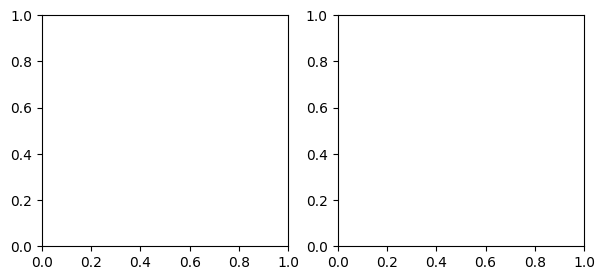

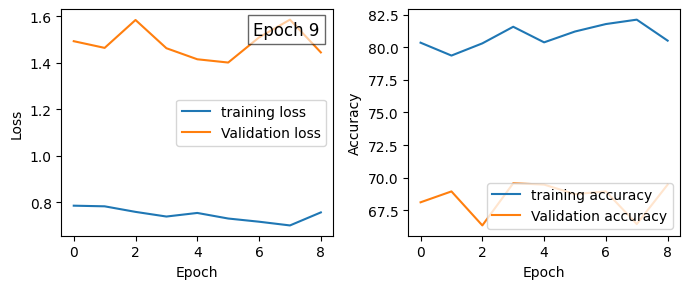

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3)) 

early_stopping = EarlyStopping(patience=10, min_delta=0.01)
max_epochs = 40
early_stopping = EarlyStopping(patience=3)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

for epoch in range(max_epochs):
    exp1.run(num_epochs=epoch + 1, plot=lambda exp: plot(exp, fig=fig, axes=axes))
    
    # Get latest validation loss
    val_loss = exp1.history[-1][1]['loss']  # -1 = last epoch
    
    early_stopping.step(val_loss)
    
    if early_stopping.should_stop:
        print(f"Stopping early at epoch {exp1.epoch}")
        break

In [58]:
# evaluation of vgg
exp1.evaluate()

{'loss': 1.4442323113481204, 'accuracy': tensor(69.4792, device='cuda:0')}

## 5. Transfer Learning 2 - ResNet18

In [59]:
resnet = tv.models.resnet18(pretrained=True)

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
# network structure
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
class Resnet18Transfer(Classifier):
    def __init__(self, num_classes, fine_tuning=False, dropout_p=0.5): # Add dropout probability as an argument
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        
        # Freeze or unfreeze layers based on fine_tuning flag
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
            
        self.classifier = resnet
        num_ftrs = resnet.fc.in_features
        
        # **MODIFICATION HERE**
        # Replace the final fully connected layer with a sequence
        # containing a Dropout layer and a new Linear layer.
        self.classifier.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):     
        y = self.classifier(x)
        return y

# --- When you create the model ---
# Use a dropout probability of 0.5 (a common default)


In [68]:
resnet18transfer = Resnet18Transfer(num_classes)

In [69]:
# network structure
resnet18transfer

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

In [64]:
# learnable parameters of network
for name, param in resnet18transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.conv1.weight torch.Size([64, 3, 7, 7]) False
classifier.bn1.weight torch.Size([64]) False
classifier.bn1.bias torch.Size([64]) False
classifier.layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.0.bn1.weight torch.Size([64]) False
classifier.layer1.0.bn1.bias torch.Size([64]) False
classifier.layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.0.bn2.weight torch.Size([64]) False
classifier.layer1.0.bn2.bias torch.Size([64]) False
classifier.layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.1.bn1.weight torch.Size([64]) False
classifier.layer1.1.bn1.bias torch.Size([64]) False
classifier.layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.1.bn2.weight torch.Size([64]) False
classifier.layer1.1.bn2.bias torch.Size([64]) False
classifier.layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
classifier.layer2.0.bn1.weight torch.Size([128]) False
classifier.layer2.0.bn1.bias torch.Size([128])

In [109]:
lr2 = 1e-4
net2 = Resnet18Transfer(num_classes, dropout_p=0.5)
net2 = Resnet18Transfer(num_classes)
net2 = net2.to(device)
net2.device = device

adam2 = torch.optim.Adam(net2.parameters(), lr=lr2, weight_decay=1e-4)
stats_manager2 = ClassificationStatsManager()
exp2 = nt.Experiment(net2, train_set, val_set, adam2, stats_manager2,
               output_dir="birdclass2", perform_validation_during_training=True)

In [110]:
import numpy as np
import torch

class EarlyStopper2:
    """Stops training when validation loss doesn't improve for a given number of epochs."""
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [111]:
patience = 5
early_stopper = EarlyStopper2(patience=patience, verbose=True, path='birdclass_best_model.pt')

def plot_and_early_stop_callback(exp):
    plot(exp, fig=fig, axes=axes)

    if len(exp.history) > 0:
        latest_entry = exp.history[-1]

        # New: extract train/val losses safely from the dicts
        train_stats, val_stats = latest_entry

        latest_train_loss = train_stats.get('loss', None)
        latest_val_loss = val_stats.get('loss', None)

        if latest_val_loss is None:
            print("⚠️ Validation loss missing — using training loss for early stopping instead.")
            latest_val_loss = latest_train_loss
        else:
            print(f"✅ Validation loss detected: {latest_val_loss:.4f}")

        early_stopper(latest_val_loss, exp.net)

        if early_stopper.early_stop:
            print("🛑 Early stopping triggered!")
            exp.stop()

Start/Continue training from epoch 0
Epoch 1 | Time: 120.65s | Training Loss: 5.637337 | Evaluation Loss: 5.203806
✅ Validation loss detected: 5.2038
Validation loss decreased (inf --> 5.203806). Saving model ...
Epoch 2 | Time: 120.56s | Training Loss: 5.339072 | Evaluation Loss: 5.004299
✅ Validation loss detected: 5.0043
Validation loss decreased (5.203806 --> 5.004299). Saving model ...
Epoch 3 | Time: 129.34s | Training Loss: 5.179414 | Evaluation Loss: 4.831270
✅ Validation loss detected: 4.8313
Validation loss decreased (5.004299 --> 4.831270). Saving model ...
Epoch 4 | Time: 133.94s | Training Loss: 5.009861 | Evaluation Loss: 4.669543
✅ Validation loss detected: 4.6695
Validation loss decreased (4.831270 --> 4.669543). Saving model ...
Epoch 5 | Time: 133.27s | Training Loss: 4.887672 | Evaluation Loss: 4.521175
✅ Validation loss detected: 4.5212
Validation loss decreased (4.669543 --> 4.521175). Saving model ...
Epoch 6 | Time: 142.42s | Training Loss: 4.748491 | Evaluation 

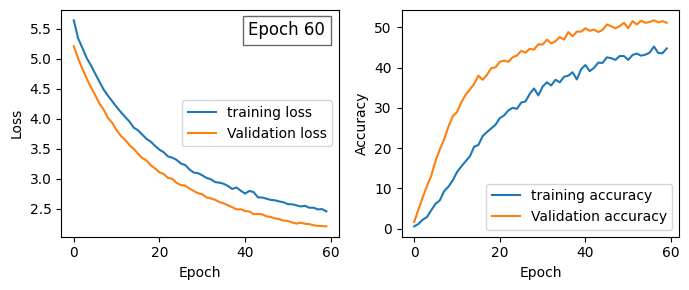

In [112]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

exp2.run(num_epochs=60, plot=plot_and_early_stop_callback)

In [ ]:
#fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
#exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [114]:
# evaluation of resnet
exp2.evaluate()

{'loss': 2.202969270944595, 'accuracy': tensor(51.1458, device='cuda:0')}

## Testing

In [146]:
test_set = BirdDataset(dataset_root_dir, mode="test")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/test.txt


In [147]:
test_loader = td.DataLoader(test_set, batch_size = 32, shuffle = False, pin_memory = True)

print(f"Found {len(test_set)} images in the test set.")

Found 1204 images in the test set.


In [148]:
model_to_test_vgg = VGG16(num_classes=num_classes)

vgg_model_path = 'birdclass1/checkpoint.pth.tar'

checkpoint_vgg = torch.load(vgg_model_path)
model_to_test_vgg.load_state_dict(checkpoint_vgg['Net']) 

model_to_test_vgg.to(device)

print(f"Successfully loaded VGG16 model weights from '{vgg_model_path}'")

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\benji\AppData\Local\Temp\ipykernel_31556\1858693742.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://githu

Successfully loaded VGG16 model weights from 'birdclass1/checkpoint.pth.tar'


In [149]:
model_to_test_resnet = Resnet18Transfer(num_classes=num_classes, dropout_p=0.5)

resnet_model_path = 'birdclass2/checkpoint.pth.tar'

checkpoint_resnet = torch.load(resnet_model_path)
model_to_test_resnet.load_state_dict(checkpoint_resnet['Net']) 

model_to_test_resnet.to(device)

print(f"Successfully loaded ResNet18 model weights from '{resnet_model_path}'")

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\benji\AppData\Local\Temp\ipykernel_31556\1120897080.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

Successfully loaded ResNet18 model weights from 'birdclass2/checkpoint.pth.tar'


In [150]:
def test_model(model, test_loader, device):
    """Evaluates a trained model on the test dataset."""
    
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()
    
    correct_predictions = 0
    total_samples = 0
    
    # Disable gradient calculations for speed
    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions
            outputs = model(images)
            
            # Get the class with the highest probability
            _, predicted_class = torch.max(outputs.data, 1)
            
            # Tally correct predictions
            total_samples += labels.size(0)
            correct_predictions += (predicted_class == labels).sum().item()
            
    # Calculate and display the final accuracy
    accuracy = 100 * correct_predictions / total_samples
    print("-----------------------------------")
    print(f"Accuracy on the test set: {accuracy:.2f}%")
    print("-----------------------------------")
    
    return accuracy

In [151]:
print("Testing the VGG16 model...")
test_accuracy_vgg = test_model(model_to_test_vgg, test_loader, device)

Testing the VGG16 model...
-----------------------------------
Accuracy on the test set: 67.11%
-----------------------------------


In [152]:
print("\nTesting the ResNet18 model...")
test_accuracy_resnet = test_model(model_to_test_resnet, test_loader, device)


Testing the ResNet18 model...
-----------------------------------
Accuracy on the test set: 51.00%
-----------------------------------
